In [1]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/int3405-sentiment-analysis-problem/test.csv
/kaggle/input/int3405-sentiment-analysis-problem/full_train.csv
/kaggle/input/foody-crawl/test_raw.csv
/kaggle/input/foody-crawl/test_raw_search.csv
/kaggle/input/foody-crawl/train_raw.csv
/kaggle/input/foody-crawl/data_train_crawl.csv
/kaggle/input/foody-crawl/mix_raw.csv
/kaggle/input/foody-crawl/data_mix_crawl.csv


In [2]:
import torch
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm

!pip install underthesea
from underthesea import word_tokenize

import torch.nn as nn
from torch.optim import AdamW
from torch.utils.data import Dataset, DataLoader

!pip install transformers
from transformers import get_linear_schedule_with_warmup, AutoTokenizer, AutoModel, logging

import warnings
warnings.filterwarnings("ignore")

logging.set_verbosity_error()

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.0/11.0 MB 10.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 965.4/965.4 kB 44.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 591.7/591.7 kB 35.5 MB/s eta 0:00:00


In [3]:
# For Reproducibility
def seed_everything(seed_value):
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    
    if torch.cuda.is_available(): 
        torch.cuda.manual_seed(seed_value)
        torch.cuda.manual_seed_all(seed_value)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = True

seed_everything(2120)

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [5]:
train_df = pd.read_csv('/kaggle/input/foody-crawl/data_mix_crawl.csv')
test_df = pd.read_csv('/kaggle/input/foody-crawl/test_raw_search.csv')

In [6]:
import re

emoji_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        u"\U0001f926-\U0001f937"
        u'\U00010000-\U0010ffff'
        u"\u200d"
        u"\u2640-\u2642"
        u"\u2600-\u2B55"
        u"\u23cf"
        u"\u23e9"
        u"\u231a"
        u"\u3030"
        u"\ufe0f"
    "]+", flags=re.UNICODE)
def remove_emoji(text):
    return emoji_pattern.sub(r' ', text)

def remove_punctuations(text):
    return re.sub(r'[^\w\s]', '', text)

ICONS = [':)))))', ':))))', ':)))', ':))', ':)', ':D', ':v' \
    ':(((((', ':((((', ':(((', ':((', ':(' \
        '(y)', ':">', ':\'(', ':|', ':-)' 
]
def remove_icons(text):
    for icon in ICONS:
        text = text.replace(icon, ' ')
    return text


def preprocess(text):
    if text == '':
        return ''
    text = text.lower().strip().replace('\n', ' ')
    text = remove_emoji(text)
    text = remove_punctuations(text)
    text = remove_icons(text)
    return text


train_df.dropna(inplace=True)
train_df.fillna('', inplace=True)
train_df['Comment'] = train_df['Comment'].apply(preprocess)
test_df.fillna('', inplace=True)
test_df['Comment'] = test_df['Comment'].apply(preprocess)

In [7]:
train_df.sample(5)

,RevId,UserId,Comment,image_urls,Rating
28524,3435198,587449,theo mình chân gà ở đây ăn cũng được điểm cộng...,"['/ha-noi/hashtag/changaxaot-224729""}],""Pictur...",6.4
14343,13952309,25468812,chả hiểu sao mng chê chứ mình ăn ở đây 5 năm r...,[],5.0
13056,4416960,593185,ốc béo sạch ngon có thêm tí riêu cua chắc bes...,['https://images.foody.vn/res/g101/1004261/s80...,8.6
10807,3115848,9536443,mình rất không hài lòng khi gọi đồ ship về thì...,[],4.4
22304,3050134,1838944,định ăn thử xem có ok k nên 2 đứa chỉ gọi sươn...,['https://images.foody.vn/res/g14/134242/s800/...,7.4


In [8]:
test_df.sample(5)

,Unnamed: 0,RevId,UserId,Comment,image_urls,Rating
3644,3644,2034166,8755271,cháo ngon và đầy đặn phết khi có đầy đủ sườn s...,['https://images.foody.vn/res/g17/163349/s800/...,7.4
618,618,5998847,914390,cơm ngon nêm nếm vừa miệng siêu đầy đặn bắt mắ...,['https://images.foody.vn/res/g97/961921/s800/...,9.6
268,268,9348347,18101220,1010 tuyệt không có gì để chê vừa healthy lại ...,['https://images.foody.vn/res/g104/1033903/s80...,10.0
2036,2036,3459501,15831180,trong các quán bún chả thích mình thấy quán bú...,['https://images.foody.vn/res/g94/935781/s800/...,9.6
2849,2849,3450552,13821273,từ sài gìn ra hà nội ăn bún đậu lần t2 nhưng t...,['https://images.foody.vn/res/g95/940978/s800/...,7.6


In [9]:
train_df.info(), test_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 36016 entries, 0 to 36015
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   RevId       36016 non-null  int64  
 1   UserId      36016 non-null  int64  
 2   Comment     36016 non-null  object 
 3   image_urls  36016 non-null  object 
 4   Rating      36016 non-null  float64
dtypes: float64(1), int64(2), object(2)
memory usage: 1.6+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5103 entries, 0 to 5102
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  5103 non-null   int64  
 1   RevId       5103 non-null   int64  
 2   UserId      5103 non-null   int64  
 3   Comment     5103 non-null   object 
 4   image_urls  5103 non-null   object 
 5   Rating      5103 non-null   float64
dtypes: float64(1), int64(3), object(2)
memory usage: 239.3+ KB


(None, None)

<AxesSubplot:title={'center':'Train Rating distribution'}>

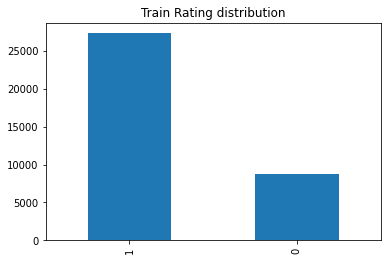

In [10]:
train_df['label'] = train_df['Rating'].apply(lambda x: int(x > 6.0))
train_df['label'].value_counts().plot(kind='bar', title='Train Rating distribution')

<AxesSubplot:title={'center':'Test Rating distribution'}>

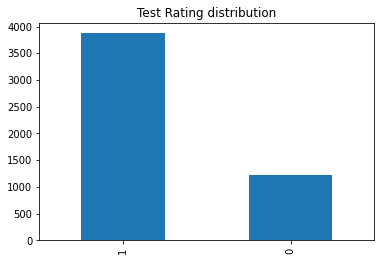

In [11]:
test_df['label'] = train_df['Rating'].apply(lambda x: int(x > 6.0))
test_df['label'].value_counts().plot(kind='bar', title='Test Rating distribution')

In [12]:
tokenizer = AutoTokenizer.from_pretrained("vinai/phobert-base", use_fast=True, force_download=True)

Downloading:   0%|          | 0.00/557 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/874k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.08M [00:00<?, ?B/s]

In [13]:
class SentimentDataset(Dataset):
    def __init__(self, df, tokenizer, max_len=120, train=True):
        self.df = df
        self.max_len = max_len
        self.tokenizer = tokenizer
        self.train = train
    
    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        """
        To customize dataset, inherit from Dataset class and implement
        __len__ & __getitem__
        __getitem__ should return 
            data:
                input_ids
                attention_masks
                text
                targets
        """
        row = self.df.iloc[index]
        if self.train:
            revid, text, label = self.get_input_data(row, self.train)
        else:
            revid, text = self.get_input_data(row, self.train)

        # Encode_plus will:
        # (1) split text into token
        # (2) Add the '[CLS]' and '[SEP]' token to the start and end
        # (3) Truncate/Pad sentence to max length
        # (4) Map token to their IDS
        # (5) Create attention mask
        # (6) Return a dictionary of outputs
        encoding = self.tokenizer.encode_plus(
            text,
            truncation=True,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            return_attention_mask=True,
            return_token_type_ids=False,
            return_tensors='pt',
        )
        
        if self.train:
            return {
                'revid': revid,
                'text': text,
                'input_ids': encoding['input_ids'].flatten(),
                'attention_masks': encoding['attention_mask'].flatten(),
                'targets': torch.tensor(label, dtype=torch.float),
            }
        else:
            return {
                'revid': revid,
                'text': text,
                'input_ids': encoding['input_ids'].flatten(),
                'attention_masks': encoding['attention_mask'].flatten(),
            }

    def get_input_data(self, row, train=True):
        # Preprocessing: {remove icon, special character, lower}
        text = row['Comment']
        text = ' '.join(word_tokenize(text))
        revid = row['RevId']
        if train:   
            label = row['Rating'] / 10.0
            return revid, text, label
        return revid, text

In [14]:
# # Distribution of length of Comment
# all_data = train_df.Comment.tolist() + test_df.Comment.tolist()
# all_data = [' '.join(word_tokenize(text)) for text in all_data]
# encoded_text = [tokenizer.encode(text, add_special_tokens=True) for text in all_data]
# token_lens = [len(text) for text in encoded_text]
# sns.displot(token_lens)
# plt.xlim([0,max(token_lens)])
# plt.xlabel('Token Count')

In [15]:
class SentimentClassifier(nn.Module):
    def __init__(self):
        super(SentimentClassifier, self).__init__()
        self.bert = AutoModel.from_pretrained("vinai/phobert-base")

#         for param in self.bert.parameters():
#             param.requires_grad = False

        self.drop = nn.Dropout(p=0.1)
        self.fc = nn.Linear(self.bert.config.hidden_size, 1)
        nn.init.normal_(self.fc.weight, std=0.02)
        nn.init.normal_(self.fc.bias, 0)

    def forward(self, input_ids, attention_mask):
        last_hidden_state, output = self.bert(
            input_ids=input_ids,
            attention_mask=attention_mask,
            return_dict=False # Dropout will errors if without this
        )
        x = output
        x = self.drop(x)
        x = self.fc(x)
        return x

In [16]:
def train_one_epoch(model, criterion, optimizer, train_loader):
    model.train()
    epoch_loss = 0.

    for data in tqdm(train_loader):
        input_ids = data['input_ids'].to(device)
        attention_mask = data['attention_masks'].to(device)
        targets = data['targets'].to(device)
        # targets = targets.unsqueeze(1).float()
        optimizer.zero_grad()
        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask
        )
        outputs = torch.squeeze(torch.sigmoid(outputs))

        loss = criterion(outputs, targets)
        epoch_loss += loss.item()
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        lr_scheduler.step()

    print(f'Train Loss: {epoch_loss / len(train_loader)}')
    return epoch_loss / len(train_loader)

In [17]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

def val_one_epoch(model, test_loader):
    model.eval()
    pre = {}
    gt = {}

    for data in tqdm(test_loader):
        input_ids = data['input_ids'].to(device)
        attention_mask = data['attention_masks'].to(device)
        targets = data['targets'].detach().cpu().numpy().tolist()
        revid = data['revid']
        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask
        )
        outputs = torch.squeeze(torch.sigmoid(outputs))
        outputs = outputs.detach().cpu().numpy().tolist()
#         print(revid)
        for i in range(len(revid)):
            pre[revid[i]] = outputs[i]
            gt[revid[i]] = targets[i]
    
    pre = [int(pre[i] > 0.6) for i in sorted(pre.keys())]
    gt = [int(gt[i] > 0.6) if gt[i] > 0 else 1 for i in sorted(gt.keys())]

    acc = accuracy_score(gt, pre)
    precision = precision_score(gt, pre)
    recall = recall_score(gt, pre)
    f1 = f1_score(gt, pre)
    roc_auc = roc_auc_score(gt, pre)
    return acc, precision, recall, f1, roc_auc
    

In [18]:
def infer(model, test_loader, subname, ckpt=None):
    model.eval()
    if ckpt is not None:
        model.load_state_dict(torch.load(ckpt))
    test_revids = []
    test_rating = []

    for data in tqdm(test_loader):
        input_ids = data['input_ids'].to(device)
        attention_mask = data['attention_masks'].to(device)
        revid = data['revid']
        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask
        )
        outputs = torch.squeeze(torch.sigmoid(outputs))
        outputs = outputs.detach().cpu().numpy().tolist()
        outputs = [int(out > 0.6) for out in outputs]
        revid = revid.cpu().numpy().tolist()
        test_revids.extend(revid)
        test_rating.extend(outputs)
        
    out = pd.DataFrame({'RevId': test_revids, 'Rating': test_rating})
    out.sort_values(by=['RevId'], inplace=True)
    out.to_csv(f'submission_{str(subname)}.csv', index=False) 
        
#     return test_revids, test_rating

In [19]:
train_dataset = SentimentDataset(train_df, tokenizer, max_len=256)
test_dataset = SentimentDataset(test_df, tokenizer, max_len=256)

train_loader = DataLoader(train_dataset, batch_size=32, pin_memory=True, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=32, pin_memory=True, shuffle=False, num_workers=2)

In [20]:
 model = SentimentClassifier().to(device)

Downloading:   0%|          | 0.00/518M [00:00<?, ?B/s]

In [21]:
EPOCHS = 15
WARM_UP_EPOCHS = 5
MAX_PATIENCE = 3

In [22]:
criterion = nn.MSELoss().to(device)
optimizer = AdamW(model.parameters(), lr=5e-5)
lr_scheduler = get_linear_schedule_with_warmup(
            optimizer, 
            num_warmup_steps=len(train_loader)*WARM_UP_EPOCHS, 
            num_training_steps=len(train_loader)*EPOCHS
        )

In [23]:
best_loss = 1e9
best_roc = 0
best_acc = 0
patience = 0

for epoch in range(EPOCHS):
    print(f'Epoch {epoch+1}/{EPOCHS}')
    print('-'*30)

    epoch_loss = train_one_epoch(model, criterion, optimizer, train_loader)
    
    if epoch == 0 or (epoch + 1) % 5 == 0 or epoch == EPOCHS - 1:
        torch.save(model.state_dict(), f'./epoch_{epoch}.pth')
    
    if epoch < WARM_UP_EPOCHS:
        continue
        
    print('Validation epoch {}'.format(epoch+1))
    
#     acc, precision, recall, f1, roc_auc = val_one_epoch(model, train_loader)
#     print('Train metrics:')
#     print(f'Accuracy: {acc}')
#     print(f'Precision: {precision}')
#     print(f'Recall: {recall}')
#     print(f'F1: {f1}')
#     print(f'ROC AUC: {roc_auc}')
    
    acc, precision, recall, f1, roc_auc = val_one_epoch(model, test_loader)
    print('Test metrics:')
    print(f'Accuracy: {acc}')
    print(f'Precision: {precision}')
    print(f'Recall: {recall}')
    print(f'F1: {f1}')
    print(f'ROC AUC: {roc_auc}')
    
    if roc_auc > best_roc:
        best_roc = roc_auc
        torch.save(model.state_dict(), 'best_roc.pth')
    
    if acc > best_acc:
        best_acc = acc
        torch.save(model.state_dict(), 'best_acc.pth')
            
    if epoch_loss < best_loss:
        best_loss = epoch_loss
        torch.save(model.state_dict(), 'best_loss.pth')
        patience = 0
    else:
        patience += 1
        
    if patience == MAX_PATIENCE:
        break
        
    infer(model, test_loader, subname=epoch)

Epoch 1/15
------------------------------


100%|██████████| 1126/1126 [13:56<00:00,  1.35it/s]


Train Loss: 0.02686457143687903
Epoch 2/15
------------------------------


100%|██████████| 1126/1126 [13:57<00:00,  1.34it/s]


Train Loss: 0.016136984872676393
Epoch 3/15
------------------------------


100%|██████████| 1126/1126 [13:58<00:00,  1.34it/s]


Train Loss: 0.014152134666517113
Epoch 4/15
------------------------------


100%|██████████| 1126/1126 [13:58<00:00,  1.34it/s]


Train Loss: 0.012841884293684448
Epoch 5/15
------------------------------


100%|██████████| 1126/1126 [13:58<00:00,  1.34it/s]


Train Loss: 0.0117447424138653
Epoch 6/15
------------------------------


100%|██████████| 1126/1126 [13:58<00:00,  1.34it/s]


Train Loss: 0.010289273249791012
Validation epoch 6


100%|██████████| 160/160 [00:39<00:00,  4.08it/s]


Test metrics:
Accuracy: 0.9451303155006858
Precision: 0.9577156743620899
Recall: 0.973807758833704
F1: 0.9656946826758147
ROC AUC: 0.9045175157804883


100%|██████████| 160/160 [00:39<00:00,  4.10it/s]


Epoch 7/15
------------------------------


100%|██████████| 1126/1126 [13:59<00:00,  1.34it/s]


Train Loss: 0.008382641532512954
Validation epoch 7


100%|██████████| 160/160 [00:39<00:00,  4.06it/s]


Test metrics:
Accuracy: 0.9488536155202821
Precision: 0.9592430858806404
Recall: 0.9770200148257969
F1: 0.9680499449136982
ROC AUC: 0.9089645528674439


100%|██████████| 160/160 [00:39<00:00,  4.07it/s]


Epoch 8/15
------------------------------


100%|██████████| 1126/1126 [14:00<00:00,  1.34it/s]


Train Loss: 0.006930701908544632
Validation epoch 8


100%|██████████| 160/160 [00:39<00:00,  4.05it/s]


Test metrics:
Accuracy: 0.9545365471291397
Precision: 0.9662674162796382
Recall: 0.9767729182110205
F1: 0.9714917670189236
ROC AUC: 0.9230455500146012


100%|██████████| 160/160 [00:39<00:00,  4.06it/s]


Epoch 9/15
------------------------------


100%|██████████| 1126/1126 [14:01<00:00,  1.34it/s]


Train Loss: 0.005517781077413513
Validation epoch 9


100%|██████████| 160/160 [00:39<00:00,  4.08it/s]


Test metrics:
Accuracy: 0.9604154418969234
Precision: 0.976456009913259
Recall: 0.9735606622189276
F1: 0.9750061865874783
ROC AUC: 0.9417992705034033


100%|██████████| 160/160 [00:39<00:00,  4.02it/s]


Epoch 10/15
------------------------------


100%|██████████| 1126/1126 [14:01<00:00,  1.34it/s]


Train Loss: 0.004409437702921571
Validation epoch 10


100%|██████████| 160/160 [00:39<00:00,  4.07it/s]


Test metrics:
Accuracy: 0.9635508524397414
Precision: 0.9851721538074893
Recall: 0.9686187299234
F1: 0.9768253177174183
ROC AUC: 0.956373758901094


100%|██████████| 160/160 [00:39<00:00,  4.00it/s]


Epoch 11/15
------------------------------


100%|██████████| 1126/1126 [14:01<00:00,  1.34it/s]


Train Loss: 0.0034133225113242784
Validation epoch 11


100%|██████████| 160/160 [00:39<00:00,  4.06it/s]


Test metrics:
Accuracy: 0.9684499314128944
Precision: 0.9894206549118388
Recall: 0.9705955028416111
F1: 0.979917674940751
ROC AUC: 0.9654113877844419


100%|██████████| 160/160 [00:39<00:00,  4.04it/s]


Epoch 12/15
------------------------------


100%|██████████| 1126/1126 [14:00<00:00,  1.34it/s]


Train Loss: 0.0026979278057104815
Validation epoch 12


100%|██████████| 160/160 [00:39<00:00,  4.03it/s]


Test metrics:
Accuracy: 0.9700176366843033
Precision: 0.9891959798994975
Recall: 0.9728193723745985
F1: 0.9809393297620531
ROC AUC: 0.9660498377024508


100%|██████████| 160/160 [00:39<00:00,  4.08it/s]


Epoch 13/15
------------------------------


100%|██████████| 1126/1126 [14:00<00:00,  1.34it/s]


Train Loss: 0.0021849076117208596
Validation epoch 13


100%|██████████| 160/160 [00:39<00:00,  4.05it/s]


Test metrics:
Accuracy: 0.9721732314324907
Precision: 0.9924337957124842
Recall: 0.9723251791450457
F1: 0.9822765851223165
ROC AUC: 0.9719580441179774


100%|██████████| 160/160 [00:39<00:00,  4.09it/s]


Epoch 14/15
------------------------------


100%|██████████| 1126/1126 [14:00<00:00,  1.34it/s]


Train Loss: 0.0017842008570663228
Validation epoch 14


100%|██████████| 160/160 [00:39<00:00,  4.08it/s]


Test metrics:
Accuracy: 0.9737409367038997
Precision: 0.9934426229508196
Recall: 0.9733135656041513
F1: 0.9832750873689466
ROC AUC: 0.9743461767414695


100%|██████████| 160/160 [00:39<00:00,  4.08it/s]


Epoch 15/15
------------------------------


100%|██████████| 1126/1126 [14:01<00:00,  1.34it/s]


Train Loss: 0.0015446886014036972
Validation epoch 15


100%|██████████| 160/160 [00:39<00:00,  4.08it/s]


Test metrics:
Accuracy: 0.9755046051342348
Precision: 0.993705941591138
Recall: 0.9752903385223622
F1: 0.9844120214490586
ROC AUC: 0.97580804804906


100%|██████████| 160/160 [00:39<00:00,  4.08it/s]


In [24]:
infer(model, test_loader, subname='roc', ckpt='best_roc.pth')

100%|██████████| 160/160 [00:39<00:00,  4.05it/s]


In [25]:
infer(model, test_loader, subname='loss', ckpt='best_loss.pth')

100%|██████████| 160/160 [00:39<00:00,  4.05it/s]


In [26]:
infer(model, test_loader, subname='acc', ckpt='best_acc.pth')

100%|██████████| 160/160 [00:39<00:00,  4.03it/s]
